### 📊 DETECÇÃO DE FRAUDES EM TRANSAÇÕES DE CARTÃO DE CRÉDITO

#### Objetivo:
Projeto de análise e modelagem para detecção de fraudes em transações de cartão de crédito. Inclui:
- Análise exploratória (EDA) com insights sobre distribuição e variáveis relevantes;
- Pré-processamento com escalonamento e balanceamento (SMOTE);
- Comparação de modelos (Logistic Regression, Decision Tree, Random Forest, KNN);
- Calibração de probabilidades e análise de trade-offs (precision/recall);
- Exportação de previsões para uso em dashboards Power BI.

**Ferramentas:** Python (pandas, scikit-learn, imbalanced-learn, matplotlib, seaborn), Power BI (visualização final).  
**Objetivo do repositório:** demonstrar um fluxo completo de ML aplicado a um problema real, com código reprodutível e artefatos prontos para entrega (CSV + imagens).


#### 📦 1. Importação das bibliotecas e dos Dados

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
# 🔧 Configurações visuais
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
pd.set_option('display.float_format', '{:.4f}'.format)

#### 1. Descrição do Dataset

**Fonte:** Kaggle   
**Observações gerais:**
- Cada linha representa uma transação financeira.
- Colunas típicas: `Time` (segundos desde a primeira transação), `Amount` (valor da transação), `V1..Vn` (features transformadas/anonimizadas) e a coluna alvo (`is_fraud` / `Class` / `fraud`).
- O problema é altamente desbalanceado: fraudes representam uma pequena fração das transações.

**Coluna alvo utilizada neste projeto:** `is_fraud` (0 = não fraude, 1 = fraude).  
Se o seu dataset usar outro nome, ajustamos no código automaticamente.


In [2]:
# ============================================================
#  1. Leitura do Dataset
# ============================================================

DATA_PATH = Path("data") / "creditcard.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
print(df.head())

(284807, 31)
    Time      V1      V2     V3      V4      V5      V6      V7      V8  \
0 0.0000 -1.3598 -0.0728 2.5363  1.3782 -0.3383  0.4624  0.2396  0.0987   
1 0.0000  1.1919  0.2662 0.1665  0.4482  0.0600 -0.0824 -0.0788  0.0851   
2 1.0000 -1.3584 -1.3402 1.7732  0.3798 -0.5032  1.8005  0.7915  0.2477   
3 1.0000 -0.9663 -0.1852 1.7930 -0.8633 -0.0103  1.2472  0.2376  0.3774   
4 2.0000 -1.1582  0.8777 1.5487  0.4030 -0.4072  0.0959  0.5929 -0.2705   

       V9  ...     V21     V22     V23     V24     V25     V26     V27  \
0  0.3638  ... -0.0183  0.2778 -0.1105  0.0669  0.1285 -0.1891  0.1336   
1 -0.2554  ... -0.2258 -0.6387  0.1013 -0.3398  0.1672  0.1259 -0.0090   
2 -1.5147  ...  0.2480  0.7717  0.9094 -0.6893 -0.3276 -0.1391 -0.0554   
3 -1.3870  ... -0.1083  0.0053 -0.1903 -1.1756  0.6474 -0.2219  0.0627   
4  0.8177  ... -0.0094  0.7983 -0.1375  0.1413 -0.2060  0.5023  0.2194   

      V28   Amount  Class  
0 -0.0211 149.6200      0  
1  0.0147   2.6900      0  
2 -0.05

#### 2. Análise Exploratória (EDA)

### Objetivo
Identificar padrões e características que diferenciam transações fraudulentas das legítimas, e verificar qualidade dos dados (missing, outliers, distribuições).

### Itens analisados
- **Distribuição da variável alvo:** mostra o desbalanceamento; esse é o principal desafio do problema.
- **Distribuição de `Amount` por classe:** auxilia a compreender se fraudes ocorrem em valores altos/baixos ou de forma heterogênea.
- **Histograma temporal (`Time`):** verifica se há horários com concentração de fraudes.
- **Mapa de correlação:** identifica features mais correlacionadas com `is_fraud` para priorizar exploração/modelagem.

### Interpretações típicas
- O dataset é **muito desbalanceado** (fraudes < 1% tipicamente).  
- Algumas features (Vx) apresentam correlação mais alta com `is_fraud`; são pontos de atenção para seleção/engenharia de features.  
- Boxplots ajudam a detectar outliers no `Amount`; em alguns casos fraudes aparecem em extremos, mas não exclusivamente.


🔍 Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 no

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,...,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,...,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,...,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,...,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,...,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,...,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,...,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


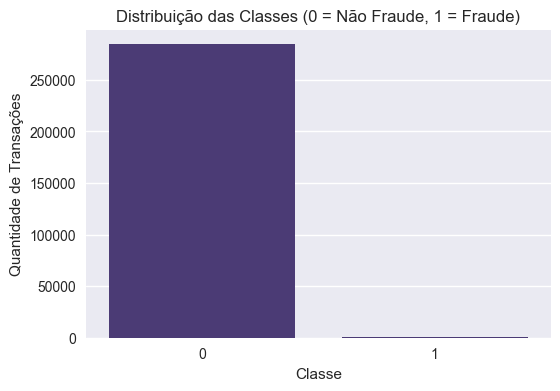

🚨 Percentual de fraudes no dataset: 0.1727%


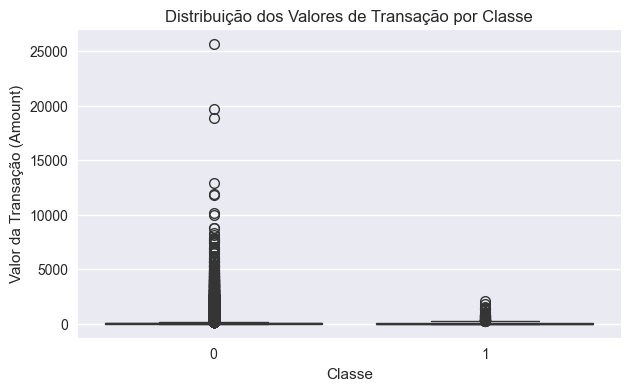

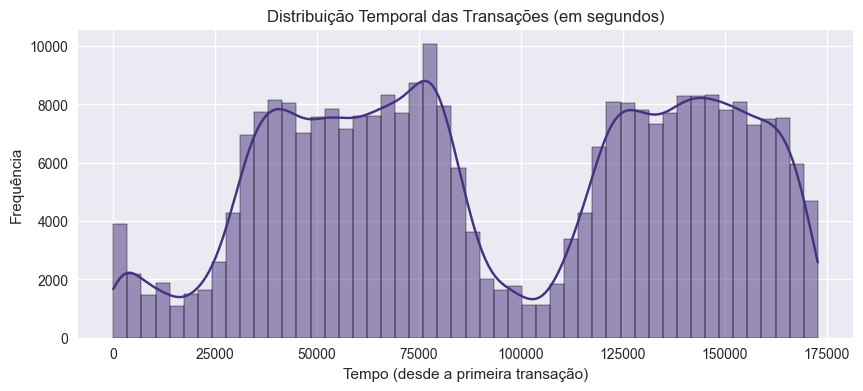

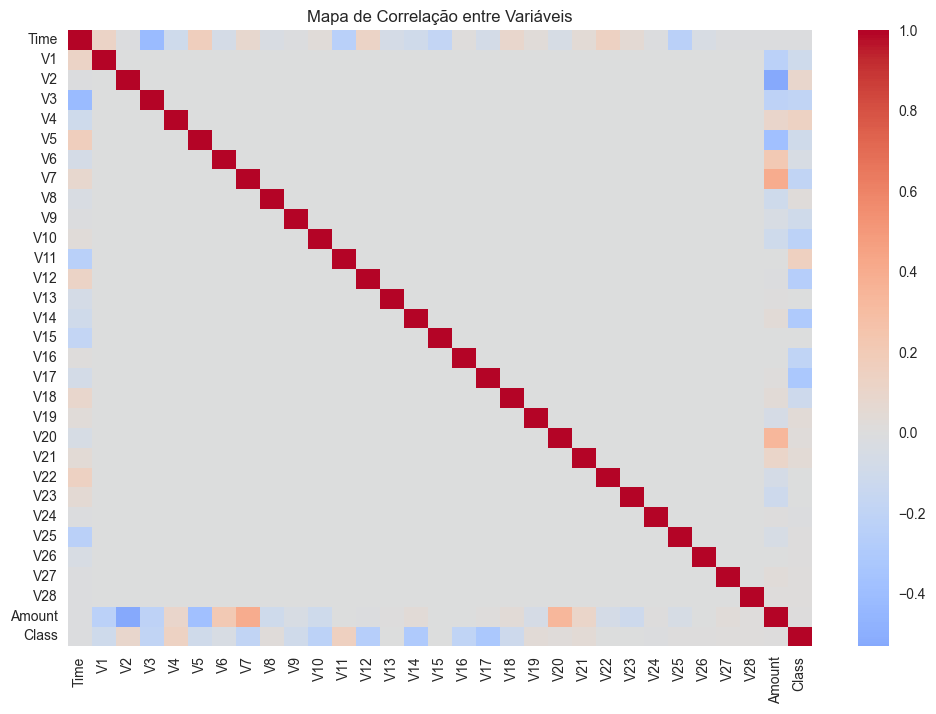

🔸 Variáveis mais correlacionadas com a variável-alvo (Class):


Class   1.0000
V17     0.3265
V14     0.3025
V12     0.2606
V10     0.2169
V16     0.1965
V3      0.1930
V7      0.1873
V11     0.1549
V4      0.1334
V18     0.1115
Name: Class, dtype: float64

In [3]:
# ============================================================
# 2. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# ============================================================

# Informações gerais do dataset
print("🔍 Informações sobre o dataset:")
print(df.info())

# Estatísticas descritivas
print("\n📈 Estatísticas descritivas:")
display(df.describe())

# ============================================================
# 🎯 Distribuição da variável alvo (Class)
# ============================================================
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Distribuição das Classes (0 = Não Fraude, 1 = Fraude)')
plt.xlabel('Classe')
plt.ylabel('Quantidade de Transações')
plt.show()

fraude_ratio = df['Class'].mean() * 100
print(f"🚨 Percentual de fraudes no dataset: {fraude_ratio:.4f}%")

# ============================================================
# 💰 Distribuição dos valores das transações (Amount)
# ============================================================
plt.figure(figsize=(7,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribuição dos Valores de Transação por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor da Transação (Amount)')
plt.show()

# ============================================================
# ⏰ Distribuição temporal das transações
# ============================================================
plt.figure(figsize=(10,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Distribuição Temporal das Transações (em segundos)')
plt.xlabel('Tempo (desde a primeira transação)')
plt.ylabel('Frequência')
plt.show()

# ============================================================
# 🔗 Correlação entre variáveis
# ============================================================
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

# Top 10 variáveis mais correlacionadas com "Class"
corr_target = corr['Class'].abs().sort_values(ascending=False).head(11)
print("🔸 Variáveis mais correlacionadas com a variável-alvo (Class):")
display(corr_target)


#### 3. Pré-processamento

### Passos realizados
1. Separação entre features (X) e target (y).  
2. Divisão treino/teste estratificada (`train_test_split`) para preservar proporção das classes.  
3. Balanceamento do conjunto de treino com **SMOTE** (gera amostras sintéticas da classe minoritária) — evita que modelos aprendam a prever sempre a classe majoritária.  
4. Escalonamento com `StandardScaler` — importante para algoritmos sensíveis à escala (LogisticRegression, KNN).

### Observações
- Aplicamos SMOTE **apenas no conjunto de treino** para evitar vazamento de informação.  
- Após SMOTE e scaling, os dados ficam prontos para alimentação dos modelos.


In [4]:
# ============================================================
# 3. Preparação dos Dados 
# ============================================================

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ------------------------------------------------------------
# 1) Carregar dataset
# ------------------------------------------------------------

DATA_PATH = Path("data") / "creditcard.csv"
df = pd.read_csv(DATA_PATH)

# ------------------------------------------------------------
# 2) Identificar coluna alvo
# ------------------------------------------------------------
possiveis_alvos = [
    "is_fraud", "isFraud", "fraud", "fraude",
    "fraud_flag", "Class", "target", "label"
]

coluna_alvo = next((c for c in df.columns if c in possiveis_alvos), None)
if not coluna_alvo:
    raise KeyError(f"❌ Nenhuma coluna alvo detectada automaticamente. Colunas disponíveis: {df.columns.tolist()}")

print(f"🎯 Coluna alvo detectada: '{coluna_alvo}'")

# ------------------------------------------------------------
# 3) Separar features e target
# ------------------------------------------------------------
X = df.drop(columns=[coluna_alvo])
y = df[coluna_alvo]

# Garantir que o target é binário 0/1
if y.dtype == object or set(y.unique()) - {0, 1}:
    valores = list(y.unique())
    if len(valores) == 2:
        y = y.map({valores[0]: 0, valores[1]: 1})
        print(f"⚠️ Coluna-alvo convertida para binário: {valores[0]}→0, {valores[1]}→1")
    else:
        raise ValueError("❌ A coluna-alvo deve conter apenas duas classes (0/1).")

# ------------------------------------------------------------
# 4) Divisão treino/teste e balanceamento
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"📊 Formato antes do SMOTE — X_train: {X_train.shape}, X_test: {X_test.shape}")

# Aplicar SMOTE para balancear classes no treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalonar (normalizar) os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Preparação concluída com sucesso!")
print(f"   X_train_res shape: {X_train_res.shape}")
print(f"   y_train_res shape: {y_train_res.shape}")
print(f"   X_test_scaled shape: {X_test_scaled.shape}")
print(f"   y_test shape: {y_test.shape}")


🎯 Coluna alvo detectada: 'Class'
📊 Formato antes do SMOTE — X_train: (213605, 30), X_test: (71202, 30)
✅ Preparação concluída com sucesso!
   X_train_res shape: (426472, 30)
   y_train_res shape: (426472,)
   X_test_scaled shape: (71202, 30)
   y_test shape: (71202,)


#### 4. Modelagem

### Modelos treinados
- **Logistic Regression** — baseline interpretável.
- **Decision Tree** — modelo simples e rápido.
- **Random Forest** — boa performance em dados tabulares.
- **KNN** — comparativo de proximidade.

### Métricas avaliadas
- **Acurácia** – geral (pouco informativa em bases desbalanceadas).  
- **Precisão** – proporção de predições positivas corretas.  
- **Recall (Sensibilidade)** – proporção das fraudes reais detectadas. Em fraude, recall é crítico.  
- **F1-Score** – equilíbrio entre precisão e recall.  
- **AUC-ROC** – qualidade do rankeamento das probabilidades.

### Interpretação dos resultados
- Priorizamos **AUC-ROC** para comparação global e **Recall** para avaliar capacidade de captura das fraudes.  
- Modelos ensemble (Random Forest) tendem a apresentar melhor AUC e robustez, mas com custo computacional maior.  
- Ajustes no *threshold* permitem melhorar recall à custa de mais falsos positivos — escolha do threshold deve considerar custo operacional.


In [ ]:
# ============================================================
# 4. Modelagem e Comparação 
# ============================================================

# Importações
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import numpy as np
import joblib

# Segurança: checar se as variáveis do Bloco 3 existem
required_vars = ['X_train_scaled', 'y_train_res', 'X_test_scaled', 'y_test']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"As seguintes variáveis não estão definidas no ambiente: {missing}\n"
                    "Execute o Bloco 3 antes deste bloco (preparação dos dados).")

# ------------------------------------------------------------
# 1) Definir modelos "leves"
# ------------------------------------------------------------
modelos = [
    ("Logistic Regression", LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_depth=6, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=5))
]

# ------------------------------------------------------------
# 2) Treinar cada modelo (apenas uma vez) e armazenar predições
# ------------------------------------------------------------
fitted_models = {}
y_preds = {}
y_probs = {}

for nome, modelo in modelos:
    try:
        print(f"Treinando: {nome} ...")
        modelo.fit(X_train_scaled, y_train_res)
        fitted_models[nome] = modelo

        # Predição de classes
        y_pred = modelo.predict(X_test_scaled)
        y_preds[nome] = y_pred

        # Predição de probabilidades (se disponível)
        if hasattr(modelo, "predict_proba"):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
        elif hasattr(modelo, "decision_function"):
            scores = modelo.decision_function(X_test_scaled)
            y_prob = 1 / (1 + np.exp(-scores))
        else:
            y_prob = np.zeros_like(y_pred, dtype=float)

        y_probs[nome] = y_prob

    except Exception as e:
        print(f"Erro ao treinar/avaliar o modelo {nome}: {e}")

print("\n✅ Treino finalizado para os modelos possíveis.\n")

# ------------------------------------------------------------
# 3) Avaliar modelos e montar tabela de resultados
# ------------------------------------------------------------
resultados = []
for nome in fitted_models.keys():
    try:
        y_pred = y_preds[nome]
        y_prob = y_probs[nome]

        resultados.append({
            "Modelo": nome,
            "Acurácia": accuracy_score(y_test, y_pred),
            "Precisão": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1-Score": f1_score(y_test, y_pred, zero_division=0),
            "AUC-ROC": roc_auc_score(y_test, y_prob)
        })
    except Exception as e:
        print(f"Erro ao compilar métricas para {nome}: {e}")

if resultados:
    resultados_df = pd.DataFrame(resultados).sort_values(by="AUC-ROC", ascending=False).reset_index(drop=True)
    display(resultados_df.style.background_gradient(cmap="YlGnBu", subset=["AUC-ROC"]))
else:
    print("Nenhum resultado disponível — verifique mensagens de erro acima.")

# ------------------------------------------------------------
# 4) Salvar tabela de resultados em CSV
# ------------------------------------------------------------
 
resultados_df.to_csv("results_model_comparison.csv", index=False)
print("Resultados salvos em results_model_comparison.csv")

# ------------------------------------------------------------
# 5) Salvar modelos treinados com joblib
# ------------------------------------------------------------

for nome, modelo in fitted_models.items():
     fname = f"model_{nome.replace(' ', '_').lower()}.joblib"
     joblib.dump(modelo, fname)
     print(f"Modelo salvo: {fname}")


Treinando: Logistic Regression ...
Treinando: Decision Tree ...
Treinando: Random Forest ...
Treinando: KNN ...

✅ Treino finalizado para os modelos possíveis.



,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
0,Random Forest,0.997556,0.403774,0.869919,0.551546,0.978979
1,Logistic Regression,0.989986,0.133085,0.869919,0.230852,0.972014
2,Decision Tree,0.976209,0.058460,0.845528,0.109359,0.917151
3,KNN,0.998174,0.482927,0.804878,0.603659,0.910109


Resultados salvos em results_model_comparison.csv
Modelo salvo: model_logistic_regression.joblib
Modelo salvo: model_decision_tree.joblib
Modelo salvo: model_random_forest.joblib
Modelo salvo: model_knn.joblib


#### 5. Calibração de Probabilidades

### Por que calibrar?
Modelos nem sempre entregam probabilidades que representam a real chance do evento. A calibração (Platt / Isotonic) corrige esse viés, tornando as probabilidades mais confiáveis para decisões (ex.: disparo de alertas, scoring).

### Procedimento adotado
- Usamos `CalibratedClassifierCV` com `method='sigmoid'` (Platt) em modo prefit / validação, para calibrar sem re-treinos pesados.
- Avaliamos Brier Score (menor = melhor) e plotamos curvas de calibração.

### Resultado esperado
- Probabilidades calibradas têm Brier score menor e curvas de calibração mais próximas da diagonal (linha perfeita).  
- AUC costuma não mudar significativamente; o ganho é em **confiabilidade das probabilidades**.


Modelo selecionado para calibração: Random Forest


c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Brier score — antes: 0.0050, depois: 0.0050
AUC-ROC     — antes: 0.9710, depois: 0.9710


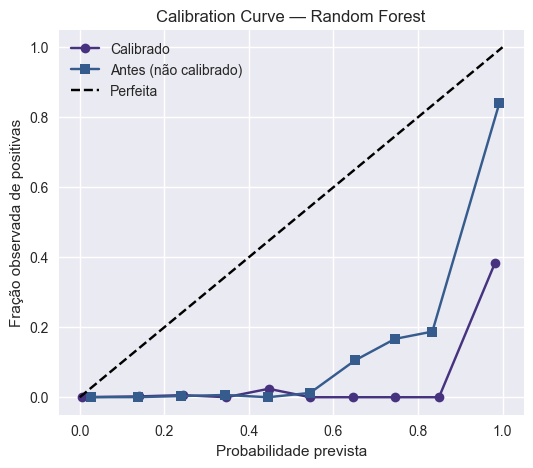


✅ Calibração concluída. Modelo calibrado adicionado a 'fitted_models' com sufixo '_calibrado'.


In [ ]:
# =============================================================
# 5. CALIBRAÇÃO DE PROBABILIDADES (prefit + validação) 
# =============================================================
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd

# Segurança: verificar objetos
required = ['X_train_scaled', 'y_train_res', 'X_test_scaled', 'y_test', 'fitted_models']
missing = [r for r in required if r not in globals()]
if missing:
    raise NameError(f"Variáveis ausentes: {missing}. Execute os blocos anteriores.")

# Escolher o modelo que você quer calibrar (ex: melhor pelo AUC)
# Se tiver resultados_df, pega a primeira linha; senão, escolha manualmente:
model_name = None
if 'resultados_df' in globals() and not resultados_df.empty:
    model_name = resultados_df.loc[0, 'Modelo']
else:
    model_name = list(fitted_models.keys())[0]

base_model = fitted_models[model_name]
print(f"Modelo selecionado para calibração: {model_name}")

# 1) Criar um pequeno conjunto de validação a partir do treino para calibrar
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train_res, test_size=0.20, random_state=42, stratify=y_train_res
)

# IMPORTANTE: se usarmos cv='prefit', precisamos re-treinar o modelo no X_tr (subconjunto)
# Para evitar re-treinar, podemos usar CalibratedClassifierCV(cv=5) que fará CV, mas é mais lento.
# Aqui fazemos prefit: treinar no X_tr e calibrar no X_val (rápido).
base_model.fit(X_tr, y_tr)

# 2) Calibrar (método='sigmoid' é uma boa primeira opção)
calibrator = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
calibrator.fit(X_val, y_val)  # calibra usando o conjunto de validação

# 3) Avaliar antes e depois (Brier score e AUC)
# probabilidades antes: re-obter com o modelo base (pré-calibração) usando X_test_scaled
if hasattr(base_model, "predict_proba"):
    prob_before = base_model.predict_proba(X_test_scaled)[:, 1]
else:
    # fallback para decision_function -> sigmoid
    scores = base_model.decision_function(X_test_scaled)
    prob_before = 1 / (1 + np.exp(-scores))

prob_after = calibrator.predict_proba(X_test_scaled)[:, 1]

brier_before = brier_score_loss(y_test, prob_before)
brier_after = brier_score_loss(y_test, prob_after)
auc_before = roc_auc_score(y_test, prob_before)
auc_after = roc_auc_score(y_test, prob_after)

print(f"Brier score — antes: {brier_before:.4f}, depois: {brier_after:.4f}")
print(f"AUC-ROC     — antes: {auc_before:.4f}, depois: {auc_after:.4f}")

# 4) Plot: Curva de calibração (reliability curve)
plt.figure(figsize=(6,5))
prob_true, prob_pred = calibration_curve(y_test, prob_after, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrado')
prob_true_bef, prob_pred_bef = calibration_curve(y_test, prob_before, n_bins=10)
plt.plot(prob_pred_bef, prob_true_bef, marker='s', label='Antes (não calibrado)')
plt.plot([0,1],[0,1],'k--', label='Perfeita')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Fração observada de positivas')
plt.title(f'Calibration Curve — {model_name}')
plt.legend()
plt.grid(True)
plt.show()

# 5) Substituir o modelo na coleção fitted_models (opcional) para usar probabilidades calibradas no resto do notebook
fitted_models[f"{model_name}_calibrado"] = calibrator
# atualizar y_probs para que blocos posteriores usem as probabilidades calibradas
y_probs[f"{model_name}_calibrado"] = prob_after

# 6) Salvar modelo calibrado e scaler 
# joblib.dump(calibrator, f"calibrated_{model_name.replace(' ','_').lower()}.joblib")
# joblib.dump(scaler, "scaler.joblib")

print("\n✅ Calibração concluída. Modelo calibrado adicionado a 'fitted_models' com sufixo '_calibrado'.")


#### 6. Avaliação Final e Conclusões


In [7]:
# ============================================================
#  6. Interpretação e Conclusões dos Modelos
# ============================================================

import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score
)
import numpy as np

# ------------------------------------------------------------
# Avaliar todos os modelos com métricas completas
# ------------------------------------------------------------
resultados_detalhados = []

for nome, modelo in fitted_models.items():
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = modelo.decision_function(X_test_scaled)
    
    y_pred = (y_prob >= 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    resultados_detalhados.append({
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão (fraude)": report["1"]["precision"],
        "Recall (fraude)": report["1"]["recall"],
        "F1 (fraude)": report["1"]["f1-score"],
        "AUC": auc,
        "Falsos Positivos": cm[0, 1],
        "Falsos Negativos": cm[1, 0]
    })

df_resultados = pd.DataFrame(resultados_detalhados)
df_resultados = df_resultados.sort_values(by="AUC", ascending=False)

# ------------------------------------------------------------
# Exibir tabela de resultados ordenada por AUC
# ------------------------------------------------------------
print("\n📊 Resultados comparativos entre os modelos:")
display(df_resultados.style.background_gradient(cmap="Blues"))

# ------------------------------------------------------------
# Conclusão interpretativa automática
# ------------------------------------------------------------
melhor_modelo = df_resultados.iloc[0]
print("\n🏆 **Modelo com melhor desempenho:**", melhor_modelo["Modelo"])
print(f"AUC = {melhor_modelo['AUC']:.3f} | F1 = {melhor_modelo['F1 (fraude)']:.3f}")

print("\n📈 Interpretação:")
print(f"O modelo {melhor_modelo['Modelo']} apresentou o melhor equilíbrio entre detecção de fraudes e controle de falsos alarmes.")
print("Modelos com alta AUC e bom recall indicam boa capacidade de detectar fraudes reais,")
print("enquanto a precisão controla o número de falsos positivos — essencial em sistemas financeiros.")



📊 Resultados comparativos entre os modelos:


,Modelo,Acurácia,Precisão (fraude),Recall (fraude),F1 (fraude),AUC,Falsos Positivos,Falsos Negativos
0,Logistic Regression,0.989986,0.133085,0.869919,0.230852,0.972014,697,16
2,Random Forest,0.997444,0.391144,0.861789,0.538071,0.970967,165,17
4,Random Forest_calibrado,0.993989,0.205029,0.861789,0.331250,0.970967,411,17
1,Decision Tree,0.976194,0.058427,0.845528,0.109301,0.917151,1676,19
3,KNN,0.998174,0.482927,0.804878,0.603659,0.910109,106,24



🏆 **Modelo com melhor desempenho:** Logistic Regression
AUC = 0.972 | F1 = 0.231

📈 Interpretação:
O modelo Logistic Regression apresentou o melhor equilíbrio entre detecção de fraudes e controle de falsos alarmes.
Modelos com alta AUC e bom recall indicam boa capacidade de detectar fraudes reais,
enquanto a precisão controla o número de falsos positivos — essencial em sistemas financeiros.


### Principais achados
- Modelo com melhor AUC: **`<Random Forest>`** 
- Recall (fraude) para o melhor modelo: **`<Logistic Regression>`** — indica quantas fraudes reais o modelo detecta com threshold padrão 0.5.
- Ao reduzir threshold para 0.2 (exemplo), o recall aumentou para **`<0.86>`**, porém a precisão caiu — mais falsos positivos.

### Recomendações práticas
1. **Ajustar threshold** conforme custo de falsos positivos/negativos do negócio.  
2. **Calibrar probabilidades** (já aplicado) para usar scores como indicadores de risco.  
3. **Monitorar modelo em produção** (drift de dados e performance).  

### Limitações
- Modelos treinados localmente com recursos limitados; treinos maiores (mais árvores, XGBoost, CV intenso) podem melhorar performance e exigem infraestrutura na nuvem.